Liz testing a little bit...Your notebooks are so nicely written, Mitchell :) 

# Quora Question Similarity Challenge Initial Analysis

The goal of this question is to predict duplicate question-answer pairs. 

The input to the model are two free-text fields, presumably representing two questions.
The ouptut from the model is a binary label, which is 1 if the questions are the same, 0 otherwise. 

The objective of this notebook is to import the training data and get a feel for the dataset. We'll try to use statistics to gain an intuitive feel for this dataset, and identify the challenges that our model will need to overcome.

First, we'll import the necessary libraries and look at the first few rows in the dataset.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

dataset = pd.read_csv('../data/train.csv')
dataset.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


First, we will take a look at the size of data, and the distribution of the labels.

In [2]:
label_count = dataset['is_duplicate'].value_counts()
print('Total number of question pairs: {0}.'.format(len(dataset['is_duplicate'])))
print('Number of non-duplicate question pairs: {0}.'.format(label_count[0]))
print('Number of duplicate question pairs: {0}.'.format(label_count[1]))

Total number of question pairs: 404290.
Number of non-duplicate question pairs: 255027.
Number of duplicate question pairs: 149263.


So, we have roughly 400k question pairs, and about 37% of them are duplicates. 
Although the are 400k question pairs, the questions themselves might not be distinct. Fortunately, the dataset gives us QuestionId, so we can count how many distinct questions there are. 

In [3]:
distinct_question_ids = set(list(dataset['qid1'] + list(dataset['qid2'])))
print('Number of distinct questions: {0}'.format(len(distinct_question_ids)))

Number of distinct questions: 347345


So, some questions are repeated. Let's see which ones appear the most often:

In [4]:
question_mention_count = {}
actual_questions = {}
for index, row in dataset.iterrows():
    if row['qid1'] not in question_mention_count:
        question_mention_count[row['qid1']] = 0
        actual_questions[row['qid1']] = row['question1']
    if row['qid2'] not in question_mention_count:
        question_mention_count[row['qid2']] = 0
        actual_questions[row['qid2']] = row['question2']
    question_mention_count[row['qid1']] += 1
    question_mention_count[row['qid2']] += 1
    
sorted_question_mention_counts = sorted([(k, question_mention_count[k]) for k in question_mention_count],\
                                        reverse=True,\
                                        key=lambda r: r[1])

Top 20 mentioned questions:
1: What are the best ways to lose weight? (157 mentions)
2: How can you look at someone's private Instagram account without following them? (120 mentions)
3: How can I lose weight quickly? (111 mentions)
4: What's the easiest way to make money online? (88 mentions)
5: Can you see who views your Instagram? (79 mentions)
6: What are some things new employees should know going into their first day at AT&T? (77 mentions)
7: What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes? (68 mentions)
8: Which is the best digital marketing course? (66 mentions)
9: How can you increase your height? (63 mentions)
10: How do l see who viewed my videos on Instagram? (61 mentions)
11: How should I start my preparation for the IAS exam? (58 mentions)
12: How would demonetizing 500 and 1000 rupee notes and introducing new 2000 rupee notes help curb black money and corruption? (57 mentions)
13: How should I lose weight? (56 mentions)
14

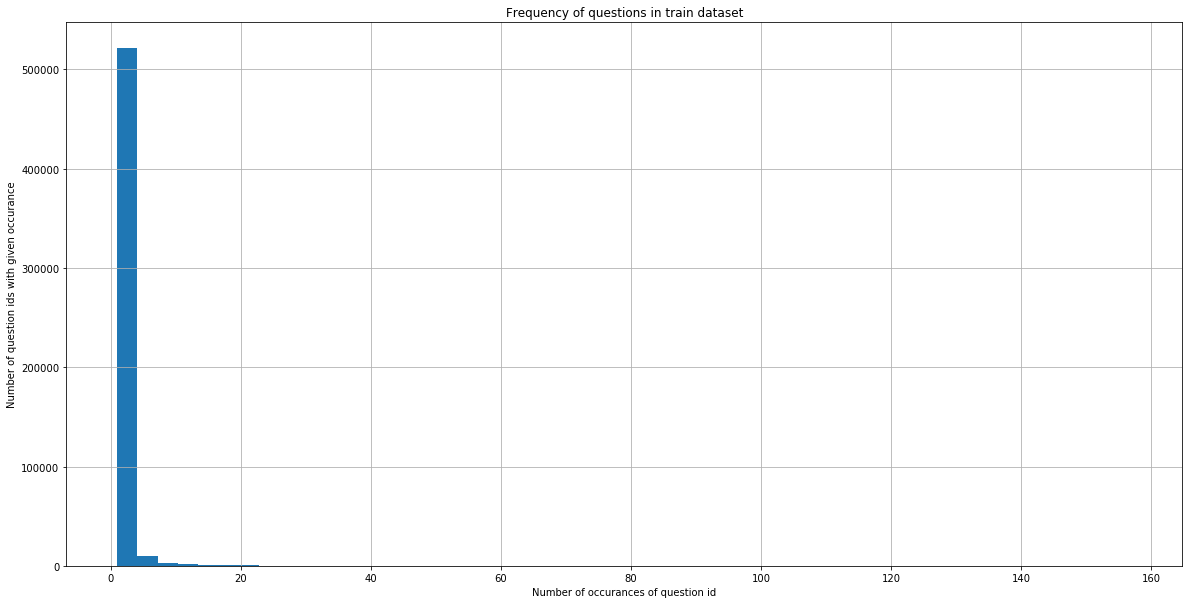

In [5]:
#Make a separate cell for display, as the above computation can take some time.
num_questions_to_examine = 20
print('Top {0} mentioned questions:'.format(num_questions_to_examine))
for i in range(0, num_questions_to_examine, 1):
    print('{0}: {1} ({2} mentions)'.format(i+1,\
                                           actual_questions[sorted_question_mention_counts[i][0]],\
                                           sorted_question_mention_counts[i][1]))
    
fig = plt.figure(figsize=(20, 10))
data_points = list(map(lambda v: v[1], sorted_question_mention_counts))
n, bins, patches = plt.hist(data_points, 50)
plt.xlabel('Number of occurances of question id')
plt.ylabel('Number of question ids with given occurance')
plt.title('Frequency of questions in train dataset')
plt.grid('on')

plt.show()

Some observations:

* The dataset appears to be very long-tailed. There are a few questions that are mentioned a bunch of times. 
* The dataset doesn't appear to be sanitized for case. Notice how number 13 and 20 on the list are the same question, differing only in case. But, they have different question IDs. 

Let's see what the labels look like for the questions that are mentioned often.

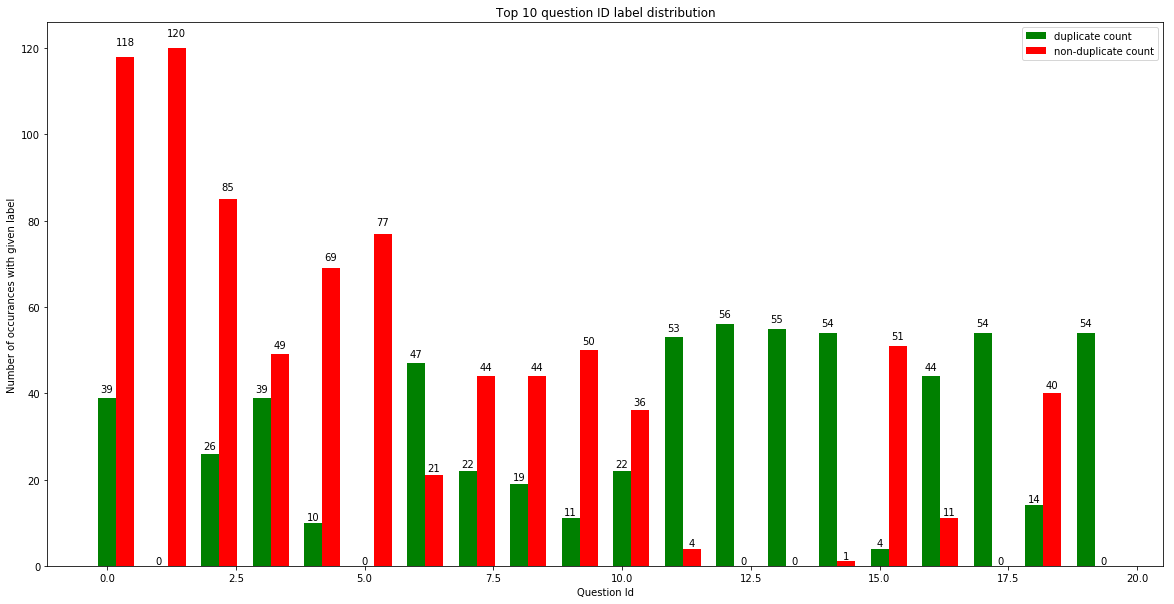

In [6]:
question_ids_of_interest = list(map(lambda v: v[0], sorted_question_mention_counts[:num_questions_to_examine]))
not_duplicate_counts = []
duplicate_counts = []

for i in range(0, len(question_ids_of_interest), 1):
    with_repeated_id = dataset[(dataset['qid1'] == question_ids_of_interest[i])\
                               | (dataset['qid2'] == question_ids_of_interest[i])]
    repeated_label_counts = with_repeated_id['is_duplicate'].value_counts()
    if 1 in repeated_label_counts.index:
        duplicate_counts.append(repeated_label_counts[1])
    else:
        duplicate_counts.append(0)
    if 0 in repeated_label_counts.index:
        not_duplicate_counts.append(repeated_label_counts[0])
    else:
        not_duplicate_counts.append(0)
        
bar_width = 0.35
idx = list(range(0, num_questions_to_examine, 1))
idx2 = list(map(lambda v: v + bar_width, idx))

fig, ax = plt.subplots(figsize=(20, 10))
r1 = ax.bar(idx, duplicate_counts, bar_width, color='g')
r2 = ax.bar(idx2, not_duplicate_counts, bar_width, color='r')

ax.set_ylabel('Number of occurances with given label')
ax.set_xlabel('Question Id')
ax.legend( (r1, r2) , ('duplicate count', 'non-duplicate count') )
ax.set_title('Top 10 question ID label distribution')

def label(rects):
   for rect in rects:
       height = rect.get_height()
       ax.text(rect.get_x() + rect.get_width() / 2., 1.02 * height, '{0}'.format(int(height)), ha='center', va='bottom')#

label(r1)
label(r2)

plt.show()

Wow. There are some questions that exist as only duplicates! Let's look at one of those in particular, the 12th most commmon question.

In [7]:
interesting_id = question_ids_of_interest[12]
df = dataset[(dataset['qid1'] == interesting_id)\
                               | (dataset['qid2'] == interesting_id)]

df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
14696,14696,28132,28133,What are some ways to lose weight fast?,How should I lose weight?,1
26691,26691,19200,28133,How can I slowly lose weight?,How should I lose weight?,1
36331,36331,3596,28133,How do I suck it up and lose weight?,How should I lose weight?,1
39190,39190,14696,28133,How can I lose 25 kg?,How should I lose weight?,1
40437,40437,5358,28133,What's the best plan to lose weight?,How should I lose weight?,1
50494,50494,19199,28133,How can I lose weight loss?,How should I lose weight?,1
54584,54584,28133,10563,How should I lose weight?,How should one change their diet to lose weight?,1
72651,72651,7016,28133,How can I lose weight safely?,How should I lose weight?,1
81038,81038,17100,28133,"I am ugly and fat, how to lose weight?",How should I lose weight?,1
85924,85924,86522,28133,How do I get rid of excessive weight?,How should I lose weight?,1


Yup, all of the question pairs where one of the questions is 'How should I lose weight?' are duplicates. Let's extend this to all questions that are mentioned more than N times ('pivot' in the code below):

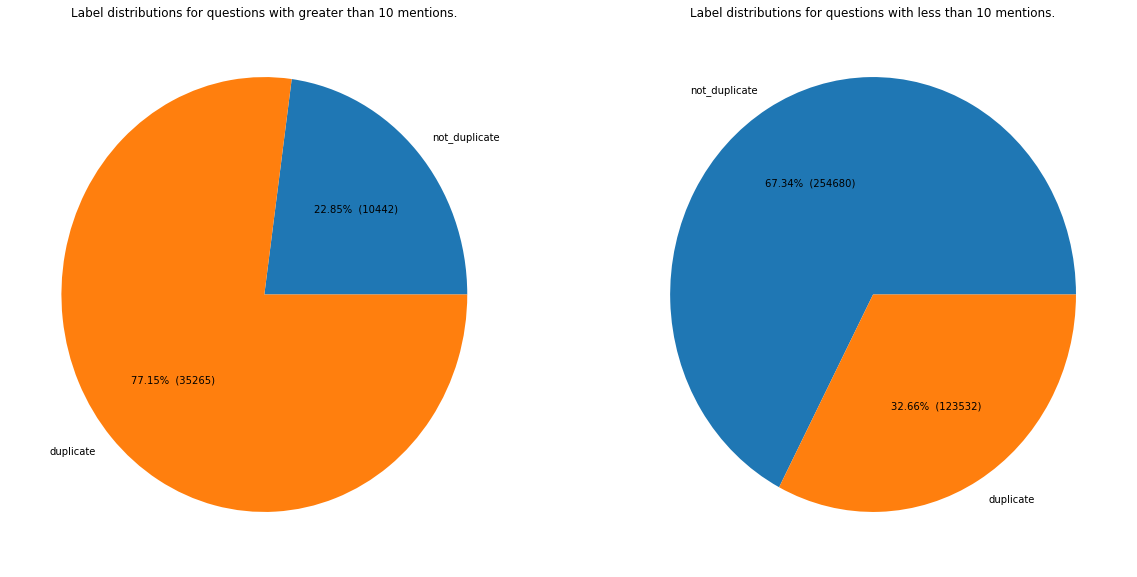

In [8]:
pivot = 10
high_repeated_count = set(map(lambda v: v[0], filter(lambda v: v[1] > pivot, sorted_question_mention_counts)))
df_with_high_repeated_count = dataset[dataset['qid1'].isin(high_repeated_count) | dataset['qid2'].isin(high_repeated_count)]
df_with_high_repeated_count_labels = df_with_high_repeated_count['is_duplicate'].value_counts()
high_data = [df_with_high_repeated_count_labels[0], df_with_high_repeated_count_labels[1]]

low_repeated_count = set(map(lambda v: v[0], filter(lambda v: v[1] <= pivot, sorted_question_mention_counts)))
df_with_low_repeated_count = dataset[dataset['qid1'].isin(low_repeated_count) | dataset['qid2'].isin(low_repeated_count)]
df_with_low_repeated_count_labels = df_with_low_repeated_count['is_duplicate'].value_counts()
low_data = [df_with_low_repeated_count_labels[0], df_with_low_repeated_count_labels[1]]


def make_autopct(values):
    def inner_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return inner_autopct

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
labels = ['not_duplicate', 'duplicate']
ax1.pie(high_data, labels=labels, autopct=make_autopct(high_data))
ax2.pie(low_data, labels=labels, autopct=make_autopct(low_data))
ax1.set_title('Label distributions for questions with greater than {0} mentions.'.format(pivot))
ax2.set_title('Label distributions for questions with less than {0} mentions.'.format(pivot))
print() # to avoid garbage vomited by matplotlib

It seems like questions that are mentioned often are more likely to be a part of a duplicate pair than not. This makes sense when you consider the workflow for these question-answering sites. Usually, the workflow is as follows:

* User asks a question
* Community develops a comprehensive, well-thought out response
* Future asks of that question are linked to the duplicate question

This suggests some sort of iterative algorithm to identify duplicate questions in the set - first find these well-linked 'centers', then attempt to expand outward.

Moving on to the text itself, let's take a look at the questions themselves. First, let's get an idea of the lengths of the questions we are working with.

In [9]:
question_id_mapping = {}
question_lengths = {}
for index, row in dataset.iterrows():
    if row['qid1'] not in question_id_mapping:
        if (pd.isnull(row['question1'])):
            question_id_mapping[row['qid1']] = ''
            question_lengths[row['qid1']] = 0
        else:
            question_id_mapping[row['qid1']] = row['question1']
            question_lengths[row['qid1']] = len(row['question1'].split())
    if row['qid2'] not in question_id_mapping:
        if (pd.isnull(row['question2'])):
            question_id_mapping[row['qid2']] = ''
            question_lengths[row['qid2']] = 0
        else:
            question_id_mapping[row['qid2']] = row['question2']
            question_lengths[row['qid2']] = len(row['question2'].split())

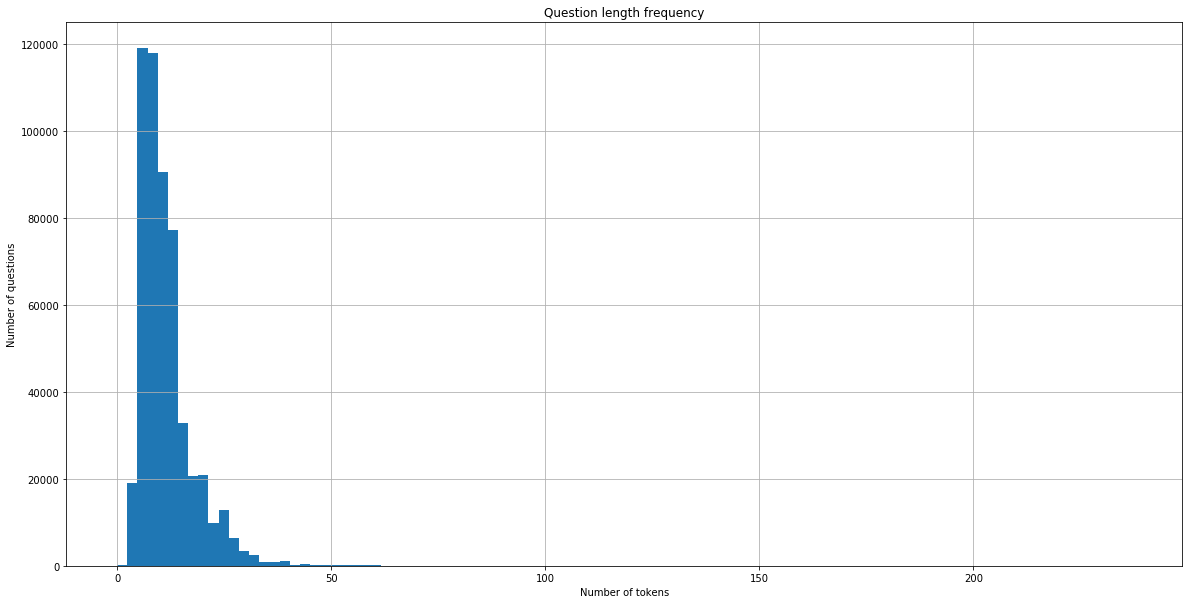

In [10]:
fig = plt.figure(figsize=(20, 10))
data_points = list(map(lambda v: question_lengths[v], question_lengths))
n, bins, patches = plt.hist(data_points, 100)
plt.xlabel('Number of tokens')
plt.ylabel('Number of questions')
plt.title('Question length frequency')
plt.grid('on')

plt.show()

We see that the vast majority of questions are short. That is, they have < 20 words. This is both a good and a bad thing:

* It's good because it means that our model won't have to parse through a bunch of irrelevant text. Consider an [example of a long-form question from stackoverflow](http://stackoverflow.com/questions/30587517/first-row-from-a-csv-file-is-a-list-of-one-string-while-the-remaining-rows-are-l?noredirect=1&lq=1). In this example, the question is "how do I parse a csv in Python?", but there is a ton of information that isn't really relevant to answering the question. Our model won't have to deal with that
* It's bad because there isn't a lot of contextual information that our model can pick up on, so we may mark questions as duplicates that are not actually duplicates because the question doesn't contain enough contextual information.

# Conclusions from this notebook

## Model Description
* Input: two free-text fields, which are presumably questions.
* Output: binary label, 1 if the questions are asking the same thing, 0 otherwise.

## Dataset Description
* 400k question pairs.
* 150k examples of duplicate questions.
* 250k examples of non-duplicate questions.
* 350k distinct questions - some questions are frequently repeated.

# Next Steps

This is a natural language processing problem. There are some fundamental building blocks that we will need:
* Cleaning. We need to remove special characters, punctuation, lemmatize / stem the text, etc.
* Word embedding model. We can start with one-hot, but that may not be sufficient. As our corpus doesn't contain much factual text, we may look to external sources to build word embedding models [wikitext](https://metamind.io/research/the-wikitext-long-term-dependency-language-modeling-dataset/)

Then, we can start looking at models:
* Tf/Idf cosine similarity: this should be quick and dirty. It may not perform well, but it can serve as a baseline on which to evaluate the more advanced models.
* Sequence RNN: RNNs have shown great promise in understanding these types of problems (LSTM, GRU, etc.). We have a large enough dataset that we can consider training one of these. 

In addition, we should think about ways to leverage the graph-like strucuture found in this notebook via an interative prediction algorithm. 